# A Beer Garden-Based Segmentation of London's Boroughs

## Note: This file was too big for GitHub (42MB) so I had to clear all but essential content

In [2]:
!pip install geopy
!pip install bs4
!pip install folium==0.5.0
!pip install -U numpy
!pip install pandas
!pip install scipy
!pip install -U scikit-learn
!pip install -U imbalanced-learn
#!pip install plotly
print('done!')

  Using cached folium-0.5.0-py3-none-any.whl
  Attempting uninstall: folium
    Found existing installation: folium 0.12.1
    Uninstalling folium-0.12.1:
      Successfully uninstalled folium-0.12.1
done!


In [1]:
import pandas as pd
import requests
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams.update({'font.size': 12})
import numpy as np
from bs4 import BeautifulSoup

print('done')

done


In [ ]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='ed7503ad-3c61-4aa5-8293-e2ff908bc10a', project_access_token='p-f99948500d0e5d3f6b58422949ef8dc7122738de')
pc = project.project_context


## 1. Import [London Boroughs data](https://data.london.gov.uk/download/land-area-and-population-density-ward-and-borough/77e9257d-ad9d-47aa-aeed-59a00741f301/housing-density-borough.csv) from csv in webpage and develop dataframe

In [3]:
# Date source 1. Save the sourcefile in a variable

London_df = pd.read_csv('housing-density-borough.csv', encoding = 'utf-8')
London_df.head()

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre
0,E09000001,City of London,1999,ONS MYE,6581,290.4,314.9,22.7,2.9,2266.2
1,E09000001,City of London,2000,ONS MYE,7014,290.4,314.9,24.2,2.9,2415.3
2,E09000001,City of London,2001,ONS MYE,7359,290.4,314.9,25.3,2.9,2534.1
3,E09000001,City of London,2002,ONS MYE,7280,290.4,314.9,25.1,2.9,2506.9
4,E09000001,City of London,2003,ONS MYE,7115,290.4,314.9,24.5,2.9,2450.1


In [4]:
London_df.drop(London_df.columns[[0, 3, 6, 7, 8, 9]], axis = 1, inplace = True)
London_df.head()

,Name,Year,Population,Inland_Area _Hectares
0,City of London,1999,6581,290.4
1,City of London,2000,7014,290.4
2,City of London,2001,7359,290.4
3,City of London,2002,7280,290.4
4,City of London,2003,7115,290.4


In [5]:
London_df = London_df[London_df.Year == 2021] # select 2021 data
London_df.head()

,Name,Year,Population,Inland_Area _Hectares
22,City of London,2021,8164,290.4
74,Barking and Dagenham,2021,221495,3610.8
126,Barnet,2021,411275,8674.8
178,Bexley,2021,256845,6058.1
230,Brent,2021,346437,4323.3


In [6]:
London_df.drop(London_df.columns[[1]], axis = 1, inplace = True)
London_df.reset_index(drop=True, inplace = True)
London_df.head()

,Name,Population,Inland_Area _Hectares
0,City of London,8164,290.4
1,Barking and Dagenham,221495,3610.8
2,Barnet,411275,8674.8
3,Bexley,256845,6058.1
4,Brent,346437,4323.3


In [ ]:
London_df

In [ ]:
London_df['Name']

In [7]:
London_df.drop(London_df.tail(3).index, inplace = True)

In [ ]:
print(London_df)

In [8]:
London_df.rename({'Name': 'Borough'}, axis=1, inplace=True)

In [ ]:
London_df

## 2. Add demographic data re population of working age and alcohol drinkers

In [9]:
# Data sources 2 and 3

df_data_2 = pd.read_csv('Working No Alcohol.csv', encoding = "utf-8")
df_data_2.head()

,Borough,Working_Age,No_Alcohol
0,City of London,73%,14%
1,Barking and Dagenham,63%,25%
2,Barnet,65%,12%
3,Bexley,63%,5%
4,Brent,68%,30%


In [10]:
London_merged = pd.merge(left=London_df, right=df_data_2, left_on='Borough', right_on='Borough')
London_merged

,Borough,Population,Inland_Area _Hectares,Working_Age,No_Alcohol
0,City of London,8164,290.4,73%,14%
1,Barking and Dagenham,221495,3610.8,63%,25%
2,Barnet,411275,8674.8,65%,12%
3,Bexley,256845,6058.1,63%,5%
4,Brent,346437,4323.3,68%,30%
5,Bromley,339466,15013.5,63%,3%
6,Camden,259344,2178.9,71%,16%
7,Croydon,403461,8650.4,65%,9%
8,Ealing,369685,5554.4,67%,13%
9,Enfield,346635,8083.2,64%,15%


In [ ]:
London_merged.dtypes

In [11]:
London_merged['Working_Age'] = London_merged['Working_Age'].str.strip('%').astype(float)
print(London_merged)
print(London_merged.dtypes)

                   Borough  Population  Inland_Area _Hectares  Working_Age  \
0           City of London        8164                  290.4         73.0   
1     Barking and Dagenham      221495                 3610.8         63.0   
2                   Barnet      411275                 8674.8         65.0   
3                   Bexley      256845                 6058.1         63.0   
4                    Brent      346437                 4323.3         68.0   
5                  Bromley      339466                15013.5         63.0   
6                   Camden      259344                 2178.9         71.0   
7                  Croydon      403461                 8650.4         65.0   
8                   Ealing      369685                 5554.4         67.0   
9                  Enfield      346635                 8083.2         64.0   
10               Greenwich      294837                 4733.4         68.0   
11                 Hackney      292023                 1904.9   

In [12]:
# Merging data sources 1 and 2

London_merged['No-Alcohol'] = London_merged['No_Alcohol'].str.strip('%').astype(float)
London_merged.head()

,Borough,Population,Inland_Area _Hectares,Working_Age,No_Alcohol,No-Alcohol
0,City of London,8164,290.4,73.0,14%,14.0
1,Barking and Dagenham,221495,3610.8,63.0,25%,25.0
2,Barnet,411275,8674.8,65.0,12%,12.0
3,Bexley,256845,6058.1,63.0,5%,5.0
4,Brent,346437,4323.3,68.0,30%,30.0


In [13]:
London_merged.drop(['No_Alcohol'], axis=1, inplace=True)
London_merged.rename({'No-Alcohol': 'No_Alcohol'}, axis=1, inplace=True)
London_merged.head()

,Borough,Population,Inland_Area _Hectares,Working_Age,No_Alcohol
0,City of London,8164,290.4,73.0,14.0
1,Barking and Dagenham,221495,3610.8,63.0,25.0
2,Barnet,411275,8674.8,65.0,12.0
3,Bexley,256845,6058.1,63.0,5.0
4,Brent,346437,4323.3,68.0,30.0


In [14]:
London_merged.rename({'Inland_Area _Hectares': 'Area km2'}, axis=1, inplace=True)
London_merged['Area km2']=London_merged['Area km2']/100
London_merged.head()

,Borough,Population,Area km2,Working_Age,No_Alcohol
0,City of London,8164,2.904,73.0,14.0
1,Barking and Dagenham,221495,36.108,63.0,25.0
2,Barnet,411275,86.748,65.0,12.0
3,Bexley,256845,60.581,63.0,5.0
4,Brent,346437,43.233,68.0,30.0


In [15]:
London_merged.rename({'Working_Age': 'Working_Age_%', 'No_Alcohol': 'Drinkers_%'}, axis=1, inplace=True)
London_merged.head()


,Borough,Population,Area km2,Working_Age_%,Drinkers_%
0,City of London,8164,2.904,73.0,14.0
1,Barking and Dagenham,221495,36.108,63.0,25.0
2,Barnet,411275,86.748,65.0,12.0
3,Bexley,256845,60.581,63.0,5.0
4,Brent,346437,43.233,68.0,30.0


In [ ]:
London_merged.dtypes

In [16]:
London_merged['Drinkers_%']=100-London_merged['Drinkers_%']
London_merged['Drinkers_%']

0     86.0
1     75.0
2     88.0
3     95.0
4     70.0
5     97.0
6     84.0
7     91.0
8     87.0
9     85.0
10    94.0
11    87.0
12    89.0
13    88.0
14    88.0
15    98.0
16    87.0
17    85.0
18    92.0
19    90.0
20    89.0
21    89.0
22    93.0
23    94.0
24    58.0
25    72.0
26    96.0
27    94.0
28    93.0
29    61.0
30    77.0
31    94.0
32    82.0
Name: Drinkers_%, dtype: float64

In [ ]:
London_merged.head()

In [17]:
London_merged['Drinkers_%'] = London_merged['Drinkers_%'].astype(int)
London_merged['Working_Age_%'] = London_merged['Working_Age_%'].astype(int)
London_merged.head()

,Borough,Population,Area km2,Working_Age_%,Drinkers_%
0,City of London,8164,2.904,73,86
1,Barking and Dagenham,221495,36.108,63,75
2,Barnet,411275,86.748,65,88
3,Bexley,256845,60.581,63,95
4,Brent,346437,43.233,68,70


In [18]:
London_merged['Pub_Pop'] = London_merged['Population']*London_merged['Working_Age_%']/100*London_merged['Drinkers_%']/100
London_merged['Pub_Pop'] = London_merged['Pub_Pop'].astype(int)
London_merged.head()

,Borough,Population,Area km2,Working_Age_%,Drinkers_%,Pub_Pop
0,City of London,8164,2.904,73,86,5125
1,Barking and Dagenham,221495,36.108,63,75,104656
2,Barnet,411275,86.748,65,88,235249
3,Bexley,256845,60.581,63,95,153721
4,Brent,346437,43.233,68,70,164904


In [19]:
London_merged['Drinkers/km2'] = London_merged['Pub_Pop']/London_merged['Area km2'].astype(int)
London_merged['Drinkers/Pop %'] = 100*London_merged['Pub_Pop']/London_merged['Population'].astype(int)

In [ ]:
London_merged.head()

In [ ]:
London_merged['Drinkers/km2'] = London_merged['Drinkers/km2'].astype(int)
London_merged['Drinkers/Pop %'] = London_merged['Drinkers/Pop %'].astype(int)
London_merged['Area km2'] = round(London_merged['Area km2'],1)

London_merged.head()

In [ ]:
London_merged.to_csv('London_demogs.csv', index=False)

## 3. Scrape [Wikipedia page](https://en.wikipedia.org/wiki/List_of_areas_of_London) for neighbourhood-level info (for Foursquare API call)

In [20]:
# Data source 3. Get the URL and save in a variable named html

URL = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
html = requests.get(URL).text

In [21]:
# Parse the html into a BS object
soup = BeautifulSoup(html, 'html5lib')

In [22]:
# Finding which table in the page contains the info we're looking for

tables = soup.find_all('table')
print(len(tables)) # How many tables are in the page?

5


In [ ]:
#for index,table in enumerate(tables):
#    if ("OS grid ref" in str(table)):
#        table_index = index
#print(table_index)

In [23]:
# check table at index 1 is the one expected by inspecting the <th> headings

headings = tables[1].find_all("th")
headings

[<th>Location</th>,
 <th>London borough</th>,
 <th>Post town</th>,
 <th>Postcode district</th>,
 <th>Dial code</th>,
 <th>OS grid ref
 </th>]

In [24]:
London = pd.read_html(str(tables[1]), encoding = "ascii")[0]
print(len(London))
London.head()

531


,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [25]:
London = London.drop(columns=['Post town', 'Postcode district', 'Dial code', 'OS grid ref'])
London.head()

KeyError: "['Postcode district' 'Dial code'] not found in axis"

In [ ]:
headings = print(London.columns.tolist())

In [26]:
London = London.drop(columns=['Post town', 'Postcode\xa0district', 'Dial\xa0code', 'OS grid ref'])
print(London.columns.tolist())

['Location', 'London\xa0borough']


In [27]:
London.columns=London.columns.str.replace('\xa0',' ')
print(London.columns.tolist())

['Location', 'London borough']


In [28]:
London.rename(columns={'Location': 'Neighbourhood', 'London borough': 'Borough'}, inplace=True)
print(London.columns.tolist())

['Neighbourhood', 'Borough']


In [ ]:
#London.rename(lambda col: col.replace('\xa0', ' '), axis='columns', inplace=True)
#print(London.columns.tolist())

In [ ]:
London.dtypes

In [29]:
London['Neighbourhood']=London['Neighbourhood'].apply(str)
London['Borough']=London['Borough'].apply(str)

In [ ]:
London['Neighbourhood'].dtype

In [ ]:
#for i in list(London.columns):
#    print(type((London[i].iloc[1])))
#    if isinstance(London[i].iloc[1], str):
#        print("It is String")
#    else:
#        print('Not a String')

In [30]:
London['Neighbourhood'] = London['Neighbourhood'].replace('Westminster','City of Westminster') # to correct a later geocoding error

In [31]:
London.head(30)

,Neighbourhood,Borough
0,Abbey Wood,"Bexley, Greenwich [7]"
1,Acton,"Ealing, Hammersmith and Fulham[8]"
2,Addington,Croydon[8]
3,Addiscombe,Croydon[8]
4,Albany Park,Bexley
5,Aldborough Hatch,Redbridge[9]
6,Aldgate,City[10]
7,Aldwych,Westminster[10]
8,Alperton,Brent[11]
9,Anerley,Bromley[11]


In [ ]:
London.to_csv('hoods_boroughs_mapping.csv', index = False)

In [32]:
hoods_boros = pd.read_csv('hoods_boroughs_mapping.csv', encoding = "ISO-8859-1")

In [33]:
hoods_boros.head()

,Neighbourhood,Borough
0,Abbey Wood,"Bexley, Greenwich [7]"
1,Acton,"Ealing, Hammersmith and Fulham[8]"
2,Addington,Croydon[8]
3,Addiscombe,Croydon[8]
4,Albany Park,Bexley


In [ ]:
hoods_boros['Neighbourhood'] = hoods_boros['Neighbourhood'].str.split('(').str[0].str.split(',').str[0].str.split('[').str[0].str.rstrip()
hoods_boros['Borough'] = hoods_boros['Borough'].str.split('(').str[0].str.split(',').str[0].str.split('[').str[0].str.rstrip()
hoods_boros.head()

In [ ]:
hoods_boros.to_csv('hoods_boroughs_mapping2.csv', index = False)

In [34]:
hoods_boros = pd.read_csv('hoods_boroughs_mapping2.csv', encoding = "utf-8")

In [35]:
hoods_list = hoods_boros['Neighbourhood'].tolist()
boros_list = hoods_boros['Borough'].tolist()

## 4. Add latitude and longitude to neighbourhoods using Geocoder Python package

In [36]:
!pip install geocoder
import geocoder # import geocoder

In [37]:
# Data source 4

latitudes_list = []
longitudes_list = []

for hood, boro in zip(hoods_list, boros_list):

    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}, Greater London'.format(hood, boro))
        lat_lng_coords = g.latlng
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
        latitudes_list.append(latitude)
        longitudes_list.append(longitude)
        print(hood, boro, latitude, longitude)

# Define Lat/Long columns in the existing df and latitude/longitude lists as the source

hoods_boros['Latitude'] = latitudes_list
hoods_boros['Longitude'] = longitudes_list

Abbey Wood Bexley 51.48688000000004 0.10746000000006006
Acton Ealing 51.50673525700006 -0.268282610999961
Addington Croydon 51.35821953400006 -0.032295274999967205
Addiscombe Croydon 51.377312062000044 -0.07454229299997905
Albany Park Bexley 51.43535896700007 0.12637773600005175
Aldborough Hatch Redbridge 51.58296961700006 0.10134761900002331
Aldgate City 51.51429097400006 -0.07567485799995666
Aldwych Westminster 51.51265251684556 -0.11860743006660546
Alperton Brent 51.54201910200004 -0.2957417139999734
Anerley Bromley 51.41200392500008 -0.06569342599993888
Angel Islington 51.532631912000056 -0.10578559999993331


KeyboardInterrupt: 

In [ ]:
hoods_boros.to_csv('neighbourhoods_lat_lng3.csv', index=False)

In [38]:
hoods_boros = pd.read_csv('neighbourhoods_lat_lng3.csv', encoding = "utf-8")

In [39]:
hoods_boros.head()

,Neighbourhood,Borough,Latitude,Longitude
0,Creekmouth,Barking and Dagenham,51.519472,0.097790
1,Barking,Barking and Dagenham,51.538171,0.078951
2,Castle Green,Barking and Dagenham,51.540203,0.165485
3,Dagenham,Barking and Dagenham,51.540203,0.165485
4,Becontree,Barking and Dagenham,51.548621,0.134050


In [ ]:
# drop neighbourhoods with same lat/Lng - keep the first

hoods_dropdups = hoods_boros.drop_duplicates(subset=['Latitude', 'Longitude'], keep='first')

In [ ]:
hoods_dropdups.to_csv('neighbourhoods_lat_lng4.csv', index=False)

In [40]:
hoods_dropdups = pd.read_csv('neighbourhoods_lat_lng4.csv', encoding = "utf-8")

In [41]:
hoods_dropdups.tail()

,Neighbourhood,Borough,Latitude,Longitude
492,Woodside Park,Barnet,51.621776,-0.190806
493,Woolwich,Greenwich,51.490467,0.063484
494,Worcester Park,Sutton,51.380803,-0.245922
495,Wormwood Scrubs,Hammersmith and Fulham,51.516279,-0.234079
496,Yiewsley,Hillingdon,51.513281,-0.472797


In [ ]:
headings = print(hoods_dropdups.columns.tolist())

## 5. Get neighbourhood venues using Foursquare venues/explore API request using neighbourhood lat/long coordinates

In [42]:
# Define Foursquare credentials

CLIENT_ID = 'ID0DZJTPDZTM4SBOMXD1JRYOV1V1T5YAIQCYOBZ10TBUJJNU' # your Foursquare ID
CLIENT_SECRET = 'B2LI1HPVOGAEGMCL0MDGOI4DZ1NNIC5K41QDCGF3XCXT0GNW' # your Foursquare Secret
#ACCESS_TOKEN = 'NOFJZU04C3XDXGCFWG5LSAHTZGPGKFCDQXIT4F2ASHLKHKTM' # your FourSquare Access Token
VERSION = '20200604'
LIMIT = 100
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: ID0DZJTPDZTM4SBOMXD1JRYOV1V1T5YAIQCYOBZ10TBUJJNU
CLIENT_SECRET:B2LI1HPVOGAEGMCL0MDGOI4DZ1NNIC5K41QDCGF3XCXT0GNW


In [43]:
# Define test API fields

categoryId = '4bf58dd8d48988d11b941735' #pubs
near = 'stoke newington, London, Greater London' #Borough
query = 'beer garden'
radius = '800' # 0.5 mile in metres
print('OK!')

OK!


## [Venues/explore](https://developer.foursquare.com/docs/api-reference/venues/explore/) 

In [44]:
# testing the geocoder

apitesthood='acton'
g = geocoder.arcgis('acton, London, Greater London'.format(apitesthood))
stokie_coords = g.latlng
#radius = 800 # hard coded in this trial example. No radius specfied in the London-wide requests (Foursquare sets radius based on local density)
latitude = stokie_coords[0]
longitude = stokie_coords[1]
print(apitesthood, latitude, longitude)

acton 51.507408360000056 -0.12769869299995662


In [45]:
# Define API URL
from pandas import json_normalize

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, query, radius, LIMIT)
print(url)
results = requests.get(url).json()
items = results['response']['groups'][0]['items']
items
stokie_df = json_normalize(items) 
stokie_df.head()

https://api.foursquare.com/v2/venues/explore?client_id=ID0DZJTPDZTM4SBOMXD1JRYOV1V1T5YAIQCYOBZ10TBUJJNU&client_secret=B2LI1HPVOGAEGMCL0MDGOI4DZ1NNIC5K41QDCGF3XCXT0GNW&ll=51.507408360000056,-0.12769869299995662&v=20200604&categoryId=4bf58dd8d48988d11b941735&query=beer garden&radius=800&limit=100


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.neighborhood,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.venuePage.id,venue.location.crossStreet
0,e-0-4acf3b84f964a520d0d220e3-0,0,"[{'summary': 'This spot is popular', 'type': '...",4acf3b84f964a520d0d220e3,The Harp,47 Chandos Pl,51.509719,-0.125943,"[{'label': 'display', 'lat': 51.50971937506041...",284,WC2N 4HS,GB,Charing Cross,Covent Garden,Greater London,United Kingdom,"[47 Chandos Pl, Covent Garden, Greater London,...","[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",0,[],NaN,NaN
1,e-0-562be808498e1e1da93d90c7-1,0,"[{'summary': 'This spot is popular', 'type': '...",562be808498e1e1da93d90c7,Mr Fogg's Tavern,58 St Martin's Ln,51.511000,-0.126952,"[{'label': 'display', 'lat': 51.51100045358756...",403,WC2N 4EA,GB,NaN,London,NaN,United Kingdom,"[58 St Martin's Ln, London, WC2N 4EA, United K...","[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",0,[],NaN,NaN
2,e-0-545bfbd6498eeac3dda21da0-2,0,"[{'summary': 'This spot is popular', 'type': '...",545bfbd6498eeac3dda21da0,The Admiralty,66 Trafalgar Sq,51.507303,-0.128847,"[{'label': 'display', 'lat': 51.50730289413475...",80,WC2N 5DS,GB,NaN,London,Greater London,United Kingdom,"[66 Trafalgar Sq, London, Greater London, WC2N...","[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",0,[],NaN,NaN
3,e-0-4ac518c3f964a5203ca420e3-3,0,"[{'summary': 'This spot is popular', 'type': '...",4ac518c3f964a5203ca420e3,Porterhouse,21-22 Maiden Ln,51.510410,-0.123653,"[{'label': 'display', 'lat': 51.51041034814778...",436,WC2E 7NA,GB,NaN,London,Greater London,United Kingdom,"[21-22 Maiden Ln, London, Greater London, WC2E...","[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",0,[],NaN,NaN
4,e-0-4ad12f23f964a52054dd20e3-4,0,"[{'summary': 'This spot is popular', 'type': '...",4ad12f23f964a52054dd20e3,Tattershall Castle,"Victoria Embankment, Temple",51.504574,-0.122543,"[{'label': 'display', 'lat': 51.504574, 'lng':...",476,SW1A 2HR,GB,NaN,London,Greater London,United Kingdom,"[Victoria Embankment, Temple, London, Greater ...","[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",0,[],NaN,NaN


In [ ]:
from random import randint
import time

### Get pubs in all neighbourhoods using auto radius (not specifying a radius variable)

In [ ]:
# Data source 5

def getHoodVenues(neighbourhoods, boroughs, latitudes, longitudes):
 
    venues_list=[]
    iter_list = []

    for hood, boro, lat, long in zip(neighbourhoods, boroughs, latitudes, longitudes):
        
# create the API request URL
    
        url = 'https://api.foursquare.com/v2/venues/explore?client_id=ID0DZJTPDZTM4SBOMXD1JRYOV1V1T5YAIQCYOBZ10TBUJJNU&client_secret=B2LI1HPVOGAEGMCL0MDGOI4DZ1NNIC5K41QDCGF3XCXT0GNW&ll={},{}&v=20200604&categoryId=4bf58dd8d48988d11b941735&query=beer garden&limit=100'.format(lat, long)
        time.sleep(2)
        
# make the GET request
        try:
            results_all = requests.get(url).json()['response']['groups'][0]['items']
        
        except:
            time.sleep(10)
            continue
                    
# return only relevant information for each nearby venue
    
        iter_list = [(hood,boro, lat, long, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['location']['formattedAddress']) for v in results_all]
        print(hood)
        venues_list.append(iter_list)
        #venues_list.append([(hood, lat, long, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['location']['formattedAddress'], v['venue']['categories'][0]['name']) for v in results])
        venues_list
        
    hood_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    hood_venues.columns = ['Neighbourhood', 'Borough', 'N_Lat', 'N_Long', 'Venue', 'V_Latitude', 'V_Longitude', 'V_Address']

    return(hood_venues)

In [ ]:
#london_venues = getHoodVenues(neighbourhoods=hoods_dropdups['Neighbourhood'], boroughs=hoods_dropdups['Borough'], latitudes=hoods_dropdups['Latitude'], longitudes=hoods_dropdups['Longitude'])
london_venues.to_csv('london_venues_no_radius.csv', encoding = "utf-8", index=False)

### ~ 49k venues in London - this is an overstatement caused by search radii 1) overlapping, resulting in duplicates across neighbourhoods and 2) returning out-of-London results

In [46]:
london_venues = pd.read_csv('london_venues_no_radius.csv',encoding = 'utf-8')
london_venues.head()
print(london_venues.shape)

(49366, 8)


In [ ]:
london_venues.dtypes

### Remove duplicates by calculating distance of pub to duplicated neighbourhood centres and assigning the pub to the closest neighbourhood, and then delete instances of the same pub in other neighbourhoods

In [47]:
london_venues['Distance'] = (1000*6371*3.14*2/360)*np.sqrt(np.square(london_venues['V_Latitude']-london_venues['N_Lat']) + np.square(london_venues['V_Longitude']-london_venues['N_Long']))

In [48]:
london_venues.head()

,Neighbourhood,Borough,N_Lat,N_Long,Venue,V_Latitude,V_Longitude,V_Address,Distance
0,Abbey Wood,Bexley,51.48688,0.10746,The Taproom SE18,51.492312,0.071515,"['15 Major Draper St (The Royal Arsenal)', 'Wo...",4040.233729
1,Abbey Wood,Bexley,51.48688,0.10746,The Rusty Bucket,51.450351,0.052161,"['11 Court Yd', 'Eltham', 'Greater London', 'S...",7365.666367
2,Abbey Wood,Bexley,51.48688,0.10746,Rose Of Denmark,51.487181,0.025820,"['296-328 Woolwich Rd', 'Charlton', 'Greater L...",9073.381089
3,Abbey Wood,Bexley,51.48688,0.10746,The Vanbrugh,51.483410,0.007991,"['91 Colomb St', 'Greenwich', 'Greater London'...",11061.590337
4,Abbey Wood,Bexley,51.48688,0.10746,Dial Arch,51.492379,0.069854,"['No 1 St, The Warren (Royal Arsenal Riverside...",4223.923464


In [ ]:
# sort by distance

london_venues = london_venues.sort_values('Distance', ascending=True)
london_venues.to_csv('venues_distance_sorted.csv', index=False)

In [ ]:
london_venues = pd.read_csv('venues_distance_sorted.csv', encoding="utf-8")

In [ ]:
london_venues.head()

### Dropping duplicates reduces the number of venues to 2594, though this still includes out-of-London results

In [ ]:
# Remove duplicate rows of venues caused by overlapping neighbourhood circles based on distance to neighbourhood centre

london_venues = london_venues.drop_duplicates(subset=['V_Address', 'Venue'], keep='first')
london_venues.to_csv('venues_distinct.csv', index=False)

In [ ]:
london_venues.shape # large decrease in results

In [49]:
london_venues = pd.read_csv('venues_distinct.csv', encoding = "utf-8")

In [50]:
london_venues.head()

,Neighbourhood,Borough,N_Lat,N_Long,Venue,V_Latitude,V_Longitude,V_Address,Distance
0,Stoke Newington,Hackney,51.561181,-0.083521,The Rose & Crown,51.561134,-0.083510,"['199 Stoke Newington Church St (Albion Rd)', ...",5.413188
1,Vauxhall,Lambeth,51.488610,-0.120720,The Black Dog,51.488599,-0.120767,"['112 Vauxhall Walk', 'London', 'Greater Londo...",5.472467
2,Crayford,Bexley,51.452837,0.177050,Crayford Arms,51.452768,0.177045,"['37 Crayford High St', 'Crayford', 'Kent', 'D...",7.697929
3,Pentonville,Islington,51.532632,-0.111394,The Chapel Bar,51.532702,-0.111432,"['29a Penton St (at Donegal St)', 'Islington',...",8.784810
4,Beddington,Sutton,51.367687,-0.132153,The Plough,51.367633,-0.132089,"['Croydon Rd', 'Beddington South', 'Greater Lo...",9.347066


In [ ]:
london_venues.drop(columns=['Neighbourhood', 'N_Lat','N_Long', 'V_Address','Distance'], inplace=True)
print(london_venues.columns.tolist())

In [ ]:
london_venues.to_csv('venues_distinct_no_rad.csv', index=False)

## 6. Correct for any inaccuracies in the Foursquare data and for out-of-London results using spatial join of pub coordinates and Borough polygons

### Firstly, understand the [London Boroughs geojsons](https://skgrange.github.io/data.html) and visualise the polygons 

In [51]:
conda install geopandas

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - geopandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.7.5   |       haa95532_1         113 KB
    ------------------------------------------------------------
                                           Total:         113 KB

The following packages will be UPDATED:

  ca-certificates                      2021.5.25-haa95532_1 --> 2021.7.5-haa95532_1




ca-certificates-2021 | 113 KB    |            |   0% 
ca-certificates-2021 | 113 KB    | #4         |  14% 
ca-certificates-2021 | 113 KB    | ########## | 100% 
ca-certificates-2021 | 113 KB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the 

In [52]:
import geopandas as gpd
import json

In [53]:
# data source 6, https://skgrange.github.io/www/data/london_boroughs.json
# visualising the raw geojson with nested dictionary

with open('london_boroughs.json') as json_data:
    london_data = json.load(json_data)
london_data

{'type': 'FeatureCollection',
 'name': 'file23f9e20d355f2',
 'features': [{'type': 'Feature',
   'properties': {'id': 1,
    'name': 'Kingston upon Thames',
    'code': 'E09000021',
    'area_hectares': 3726.117,
    'inner_statistical': False},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[-0.330679021892208, 51.3290110042255],
       [-0.330594407685802, 51.3290880335007],
       [-0.330506076800874, 51.3291488231289],
       [-0.330409170439833, 51.329208591193],
       [-0.330292080798994, 51.3292707692176],
       [-0.329913420922727, 51.3294605090526],
       [-0.329633553567758, 51.3296570521748],
       [-0.329428743782426, 51.3298420756319],
       [-0.329320874634715, 51.3299664328746],
       [-0.329214439571928, 51.3300908104757],
       [-0.329116282503008, 51.3302638658986],
       [-0.329112914697426, 51.330396008489],
       [-0.329171126657569, 51.3307295636276],
       [-0.329191261261383, 51.3309654559072],
       [-0.329302869489851, 51.331528183616

In [55]:
print(london_data['features'][0]['properties']['name'][0])
print(london_data['features'][0]['geometry']['coordinates'][0])

K
[[[-0.330679021892208, 51.3290110042255], [-0.330594407685802, 51.3290880335007], [-0.330506076800874, 51.3291488231289], [-0.330409170439833, 51.329208591193], [-0.330292080798994, 51.3292707692176], [-0.329913420922727, 51.3294605090526], [-0.329633553567758, 51.3296570521748], [-0.329428743782426, 51.3298420756319], [-0.329320874634715, 51.3299664328746], [-0.329214439571928, 51.3300908104757], [-0.329116282503008, 51.3302638658986], [-0.329112914697426, 51.330396008489], [-0.329171126657569, 51.3307295636276], [-0.329191261261383, 51.3309654559072], [-0.329302869489851, 51.3315281836161], [-0.329362730478144, 51.3316189630429], [-0.329554511276664, 51.3318716914623], [-0.32957894755712, 51.3321867794729], [-0.32959416958244, 51.3322814184113], [-0.329689959028556, 51.3324896132753], [-0.329719262959578, 51.332670781548], [-0.329718670411832, 51.3327660941938], [-0.329713610267783, 51.3328658394067], [-0.329643333902326, 51.3334961146221], [-0.329628931632214, 51.3338529136628], [

In [54]:
# visualising the geojson direclty using geopandas

london_polygons = gpd.read_file('london_boroughs.json')
london_polygons.head()

,id,name,code,area_hectares,inner_statistical,geometry
0,1,Kingston upon Thames,E09000021,3726.117,False,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,2,Croydon,E09000008,8649.441,False,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51..."
2,3,Bromley,E09000006,15013.487,False,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2..."
3,4,Hounslow,E09000018,5658.541,False,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51..."
4,5,Ealing,E09000009,5554.428,False,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."


In [56]:
polygons = london_polygons[['name','geometry']]
polygons

,name,geometry
0,Kingston upon Thames,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,Croydon,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51..."
2,Bromley,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2..."
3,Hounslow,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51..."
4,Ealing,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."
5,Havering,"MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5..."
6,Hillingdon,"MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51..."
7,Harrow,"MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51..."
8,Brent,"MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51..."
9,Barnet,"MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51..."


In [ ]:
polygons.plot() # can plot from the derived polygons dataframe

In [ ]:
polygons['name'] = polygons['name'].replace('City of London','City')
polygons

### Then get the venues points/dataframe into the right format for the spatial join

In [57]:
venues_points = pd.read_csv('venues_distinct_no_rad.csv', encoding ="utf-8")
venues_points.head()

,Borough,Venue,V_Latitude,V_Longitude
0,Hackney,The Rose & Crown,51.561134,-0.083510
1,Lambeth,The Black Dog,51.488599,-0.120767
2,Bexley,Crayford Arms,51.452768,0.177045
3,Islington,The Chapel Bar,51.532702,-0.111432
4,Sutton,The Plough,51.367633,-0.132089


In [58]:
# create geodataframe of venues points, creating combined long/lat into one column

gdf_venues_points = gpd.GeoDataFrame(venues_points, geometry=gpd.points_from_xy(venues_points['V_Longitude'], venues_points['V_Latitude']))

In [59]:
gdf_venues_points.head()

,Borough,Venue,V_Latitude,V_Longitude,geometry
0,Hackney,The Rose & Crown,51.561134,-0.083510,POINT (-0.08351 51.56113)
1,Lambeth,The Black Dog,51.488599,-0.120767,POINT (-0.12077 51.48860)
2,Bexley,Crayford Arms,51.452768,0.177045,POINT (0.17704 51.45277)
3,Islington,The Chapel Bar,51.532702,-0.111432,POINT (-0.11143 51.53270)
4,Sutton,The Plough,51.367633,-0.132089,POINT (-0.13209 51.36763)


### Venues = 2230 after spatial join to correctly assign venues to Boroughs and remove out-of-London venues

In [60]:
conda install Rtree

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [61]:
# spatial-join - correct the Boroughs and remove out-of-London venues

gdf_venues_points.crs = polygons.crs
s_join_df = gpd.sjoin(gdf_venues_points, polygons, how='right',op="within").reset_index()

In [62]:
print(s_join_df.shape)
s_join_df.head() # note new columns of name (correct Borough) geometry (Borough polygon)

(2230, 8)


,index_right,index_left,Borough,Venue,V_Latitude,V_Longitude,name,geometry
0,0,2022,Kingston upon Thames,Woodies,51.392139,-0.267327,Kingston upon Thames,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,0,172,Kingston upon Thames,The Watchman (Wetherspoon),51.398819,-0.254885,Kingston upon Thames,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
2,0,2038,Kingston upon Thames,The Star,51.326771,-0.327403,Kingston upon Thames,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
3,0,2375,Kingston upon Thames,The Shy Horse,51.337015,-0.319896,Kingston upon Thames,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
4,0,1531,Kingston upon Thames,Monkey Puzzle (Beefeater),51.346762,-0.315377,Kingston upon Thames,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."


In [ ]:
s_join_df.columns.tolist()

In [63]:
# Remove most unnecessary columns (leave old Borough column for the moment for reference)

s_join_df.drop(columns=['index_right', 'index_left', 'geometry'], inplace=True)

In [64]:
s_join_df.head()
print(s_join_df.columns.tolist())

['Borough', 'Venue', 'V_Latitude', 'V_Longitude', 'name']


In [65]:
# Remove the old Borough column, rename 'name' to 'Borough' and move to first column

venues_final = s_join_df.drop(columns=['Borough'])
venues_final = venues_final[['name', 'Venue','V_Latitude', 'V_Longitude']]
venues_final.rename(columns={'name':'Borough'}, inplace=True)
venues_final = venues_final.sort_values(['Borough','Venue'],ascending=True).reset_index(drop=True)

venues_final.to_csv('venues_final.csv', index = False)
venues_final.head()

,Borough,Venue,V_Latitude,V_Longitude
0,Barking and Dagenham,Barking Dog (Wetherspoon),51.539659,0.081583
1,Barking and Dagenham,Brewers Fayre,51.531340,0.148072
2,Barking and Dagenham,Roundhouse,51.541545,0.113742
3,Barking and Dagenham,Spotted Dog,51.539864,0.081626
4,Barking and Dagenham,Thatched House,51.533004,0.106713


In [66]:
boros_venues = []
boros_venues = venues_final.groupby('Borough').agg(Pubs=('Borough', 'count')).reset_index(drop=False)
boros_venues.to_csv('boros_venues.csv', index=False)
boros_venues

,Borough,Pubs
0,Barking and Dagenham,10
1,Barnet,37
2,Bexley,23
3,Brent,27
4,Bromley,46
5,Camden,176
6,City of London,93
7,Croydon,42
8,Ealing,55
9,Enfield,33


In [ ]:
print(boros_venues.columns.tolist())

## 7. Find the distance to the nearest venue (intra-Borough) for exploratory analysis and clustering

In [67]:
venues = pd.read_csv('venues_final.csv', encoding = "utf-8")
venues.head()
print(venues.columns.tolist())

['Borough', 'Venue', 'V_Latitude', 'V_Longitude']


In [68]:
# https://stackoverflow.com/questions/52820639/iterate-through-pandas-groups-of-coords-and-calculate-distances

from sklearn.neighbors import NearestNeighbors
import numpy as np

def distance(p1, p2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1 = p1
    lon2, lat2 = p2
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    metres = 1000*6371 * c
    return metres

boros = venues['Borough'].unique().tolist() # creating list of Boroughs to loop through
    
NN = [] # list of distance to nearest neighbour

for boro in boros:
    
    boro_xy = np.array(venues.loc[(venues['Borough'].isin([boro])), ['V_Longitude', 'V_Latitude']]) # creating np array of coords

    nbrs = NearestNeighbors(n_neighbors=2, metric=distance).fit(boro_xy)

    distances, indices = nbrs.kneighbors(boro_xy)
    result = distances[:, 1]
        
    for i in range(len(result)):
        print(boro, i, result[i])
        NN.append(result[i])

venues['NNeighbour'] = pd.DataFrame(NN).astype('int')

Barking and Dagenham 0 22.9236580302504
Barking and Dagenham 1 1227.1111325935858
Barking and Dagenham 2 1059.5462614806518
Barking and Dagenham 3 22.9236580302504
Barking and Dagenham 4 713.9603927699519
Barking and Dagenham 5 713.3507967792398
Barking and Dagenham 6 1227.1111325935858
Barking and Dagenham 7 713.3507967792398
Barking and Dagenham 8 1043.6984407521459
Barking and Dagenham 9 713.9603927699519
Barnet 0 946.6049676487878
Barnet 1 520.7137353467466
Barnet 2 715.175597367264
Barnet 3 2228.116112812387
Barnet 4 14.379309788132131
Barnet 5 303.82348568227417
Barnet 6 455.47029543163956
Barnet 7 1547.5023767810214
Barnet 8 196.9065002867081
Barnet 9 116.19369430730018
Barnet 10 1617.2397898954034
Barnet 11 70.68815285112149
Barnet 12 497.73473749754413
Barnet 13 1045.8285980186265
Barnet 14 14.379309788132131
Barnet 15 342.40696545221397
Barnet 16 308.82970152438827
Barnet 17 1617.2397898954034
Barnet 18 1188.0666187167487
Barnet 19 520.7137353467466
Barnet 20 605.842080467084

City of London 0 99.24018674398202
City of London 1 92.22003519861485
City of London 2 57.64497975038995
City of London 3 79.13220370325273
City of London 4 76.8191730941025
City of London 5 179.6642634098644
City of London 6 14.32905130130256
City of London 7 8.115397764575057
City of London 8 63.79550281573148
City of London 9 81.85129061212454
City of London 10 118.70360339724637
City of London 11 25.461929788930625
City of London 12 100.47115986709782
City of London 13 49.79405541570996
City of London 14 131.11081244760175
City of London 15 108.08867072791183
City of London 16 65.36871459688979
City of London 17 55.08655696755312
City of London 18 36.36614585248519
City of London 19 3.286253672810173
City of London 20 14.32905130130256
City of London 21 30.437237708820184
City of London 22 233.11782024998507
City of London 23 55.55806505702362
City of London 24 57.64497975038995
City of London 25 325.1360542682696
City of London 26 92.99850191742235
City of London 27 63.79550281573

Hackney 0 736.5624134509142
Hackney 1 44.50324368717161
Hackney 2 38.99909481316622
Hackney 3 285.94207362805184
Hackney 4 325.7171390297956
Hackney 5 54.17592335847044
Hackney 6 49.821561268076245
Hackney 7 41.38114590411642
Hackney 8 39.18386789697477
Hackney 9 149.36290381542835
Hackney 10 291.7896239593826
Hackney 11 291.7896239593826
Hackney 12 181.4766187961919
Hackney 13 39.18386789697477
Hackney 14 295.7428195606158
Hackney 15 194.94533622969686
Hackney 16 93.74841562865556
Hackney 17 161.392702934083
Hackney 18 326.0070521534876
Hackney 19 95.20996843827382
Hackney 20 322.3526534606292
Hackney 21 228.83341348480158
Hackney 22 147.6201510135715
Hackney 23 22.133036602738116
Hackney 24 58.77054225677215
Hackney 25 28.994097464468204
Hackney 26 93.74841562865556
Hackney 27 118.47623969762455
Hackney 28 334.9377436606958
Hackney 29 49.821561268076245
Hackney 30 103.75750133418316
Hackney 31 471.1650457289441
Hackney 32 88.80517039177224
Hackney 33 169.1404407140915
Hackney 34 169.

Havering 0 473.9221406351832
Havering 1 218.01952882247105
Havering 2 172.5686543136903
Havering 3 742.1093549654546
Havering 4 2778.9169492275582
Havering 5 289.89390285735755
Havering 6 613.7463186909391
Havering 7 2416.728328939172
Havering 8 2127.768583423511
Havering 9 746.0721331353416
Havering 10 742.1093549654546
Havering 11 585.6981877653895
Havering 12 1450.893036844391
Havering 13 2689.693536640141
Havering 14 218.01952882247105
Havering 15 2127.768583423511
Havering 16 172.5686543136903
Havering 17 123.74156458821408
Havering 18 826.5608583695829
Havering 19 1341.846120501342
Havering 20 654.4938359956477
Havering 21 473.9221406351832
Havering 22 31.591675135140356
Havering 23 1143.8105263301024
Havering 24 585.6981877653895
Havering 25 654.4938359956477
Havering 26 195.11418186996954
Havering 27 322.300881867582
Havering 28 782.658303087765
Havering 29 31.591675135140356
Hillingdon 0 77.11711730592587
Hillingdon 1 105.89324317861453
Hillingdon 2 179.23087567872696
Hillingd

Kensington and Chelsea 6 416.08718568054275
Kensington and Chelsea 7 243.15601592725
Kensington and Chelsea 8 40.849861232352254
Kensington and Chelsea 9 171.88765326400815
Kensington and Chelsea 10 124.44865307654158
Kensington and Chelsea 11 24.3304285760707
Kensington and Chelsea 12 118.17435974210548
Kensington and Chelsea 13 203.68441876328043
Kensington and Chelsea 14 237.4346785487433
Kensington and Chelsea 15 114.81879742367471
Kensington and Chelsea 16 40.849861232352254
Kensington and Chelsea 17 172.88267404677754
Kensington and Chelsea 18 142.54857549838172
Kensington and Chelsea 19 216.8274956285432
Kensington and Chelsea 20 434.6020373885142
Kensington and Chelsea 21 103.0173240799499
Kensington and Chelsea 22 7.267302169864581
Kensington and Chelsea 23 181.96050734789975
Kensington and Chelsea 24 232.10186150485947
Kensington and Chelsea 25 434.6020373885142
Kensington and Chelsea 26 52.47092720221561
Kensington and Chelsea 27 103.2982964410028
Kensington and Chelsea 28 1

Richmond upon Thames 0 140.97759836520694
Richmond upon Thames 1 170.67144302842576
Richmond upon Thames 2 471.6664540594661
Richmond upon Thames 3 81.22052889007912
Richmond upon Thames 4 38.277217387092605
Richmond upon Thames 5 74.09621107789249
Richmond upon Thames 6 144.75774774142405
Richmond upon Thames 7 437.54395784942824
Richmond upon Thames 8 144.75774774142405
Richmond upon Thames 9 251.18154281690812
Richmond upon Thames 10 61.947742593373405
Richmond upon Thames 11 51.634193233376514
Richmond upon Thames 12 313.1336753119834
Richmond upon Thames 13 181.82451009366943
Richmond upon Thames 14 69.0616647699543
Richmond upon Thames 15 150.48081345604518
Richmond upon Thames 16 457.1802717120513
Richmond upon Thames 17 48.01002836467912
Richmond upon Thames 18 94.16924097121395
Richmond upon Thames 19 1645.9124113328285
Richmond upon Thames 20 346.672656997115
Richmond upon Thames 21 38.277217387092605
Richmond upon Thames 22 1255.4328758941583
Richmond upon Thames 23 81.22052

Tower Hamlets 0 347.2475117921871
Tower Hamlets 1 257.07455684258855
Tower Hamlets 2 84.64826985742492
Tower Hamlets 3 19.797734149842174
Tower Hamlets 4 191.44310590540715
Tower Hamlets 5 169.8132830067806
Tower Hamlets 6 237.1469221360012
Tower Hamlets 7 320.8218409751706
Tower Hamlets 8 199.7213923318223
Tower Hamlets 9 77.49663639120027
Tower Hamlets 10 642.8507068284968
Tower Hamlets 11 250.1181016688742
Tower Hamlets 12 159.1624185490534
Tower Hamlets 13 244.99349857955954
Tower Hamlets 14 170.97725191405866
Tower Hamlets 15 169.8132830067806
Tower Hamlets 16 199.7213923318223
Tower Hamlets 17 120.85338845637274
Tower Hamlets 18 214.69420295979918
Tower Hamlets 19 660.0292492815805
Tower Hamlets 20 67.451542305292
Tower Hamlets 21 264.6808951307021
Tower Hamlets 22 133.09632532568608
Tower Hamlets 23 67.451542305292
Tower Hamlets 24 212.92022036630172
Tower Hamlets 25 100.40945988130561
Tower Hamlets 26 352.13944224282733
Tower Hamlets 27 84.81844495636497
Tower Hamlets 28 265.55

In [69]:
venues.head()

,Borough,Venue,V_Latitude,V_Longitude,NNeighbour
0,Barking and Dagenham,Barking Dog (Wetherspoon),51.539659,0.081583,22
1,Barking and Dagenham,Brewers Fayre,51.531340,0.148072,1227
2,Barking and Dagenham,Roundhouse,51.541545,0.113742,1059
3,Barking and Dagenham,Spotted Dog,51.539864,0.081626,22
4,Barking and Dagenham,Thatched House,51.533004,0.106713,713


In [ ]:
venues.to_csv('venues_NN.csv', index=False)

In [70]:
venues = pd.read_csv('venues_NN.csv', encoding = "utf-8")

In [71]:
#agg = venues[['Borough','NNeighbour']]
boros_NN = venues.groupby('Borough').agg(NN=('NNeighbour', 'mean')).astype('int').sort_values('NN', ascending=True).reset_index(drop=False)
print(boros_NN.columns.tolist())
boros_NN.to_csv('boros_NN_mean.csv', index=False)

['Borough', 'NN']


In [72]:
boros_NN

,Borough,NN
0,City,84
1,Westminster,106
2,Camden,144
3,Islington,170
4,Kensington and Chelsea,179
5,Tower Hamlets,195
6,Hammersmith and Fulham,199
7,Hackney,212
8,Lambeth,216
9,Southwark,226


## Finding average distance between neighbours (intra-borough)

### This analysis and its outcome won't be presented in the final report the results aren't meaningful given that you'd expect average distance between pubs to increase as Borough area increases

In [ ]:
venues = pd.read_csv('venues_NN.csv', encoding = "utf-8")
venues.head()

In [ ]:
# https://stackoverflow.com/questions/42512346/python-average-distance-between-a-bunch-of-points-in-the-x-y-plane

from scipy.spatial.distance import pdist
import numpy as np

def compute_average_distance(X):
    """
    Computes the average distance among a set of n points in the d-dimensional space.

    Arguments:
        X {numpy array} - the query points in an array of shape (n,d), 
                          where n is the number of points and d is the dimension.
    Returns:
        {float} - the average distance among the points
    """
    return np.mean(pdist(X))


In [ ]:
ave_n = [] # list of ave distance between neighbours in a Borough

boros = venues['Borough'].unique().tolist() # creating list of Boroughs to loop through

for boro in boros:
    
    boro_xy = np.array(venues.loc[venues['Borough'].isin([boro]), ['V_Longitude','V_Latitude']]) # creating np array of coords for each Borough
    ave_dist = compute_average_distance(boro_xy)
    print(boro, ave_dist*1000*6371*2*3.14/360)
    ave_n.append([boro, round(ave_dist*1000*6371*2*3.14/360)])

venues_separation = pd.DataFrame(ave_n, columns = ['Borough', 'Ave dist'])
venues_separation

In [ ]:
ave_sep = venues_separation.reset_index(drop=True)
ave_sep.to_csv('venues_separation.csv', index=False)

In [ ]:
print(ave_sep.columns.tolist())

## 8 . Join the three venue-specific dataframes (which will then be joined with the demographic dataframe)

In [73]:
boros_venues = pd.read_csv('boros_venues.csv', encoding = 'utf-8',index_col=[0])
boros_NN = pd.read_csv('boros_NN_mean.csv', encoding = 'utf-8',index_col=[0])
ave_sep = pd.read_csv('venues_separation.csv', encoding = 'utf-8',index_col=[0])

In [74]:
boros_pubs_NN = pd.concat([boros_venues, boros_NN, ave_sep], axis=1).reset_index()
boros_pubs_NN['Borough'] = boros_pubs_NN['Borough'].replace('City','City of London')
boros_pubs_NN.to_csv('boros_pubs_NN.csv', index=False)
boros_pubs_NN

,Borough,Pubs,NN,Ave dist
0,Barking and Dagenham,10.0,745.0,4447.0
1,Barnet,37.0,720.0,6269.0
2,Bexley,23.0,765.0,4215.0
3,Brent,27.0,558.0,5338.0
4,Bromley,46.0,589.0,7846.0
5,Camden,176.0,144.0,3382.0
6,City of London,93.0,NaN,NaN
7,Croydon,42.0,549.0,4592.0
8,Ealing,55.0,399.0,4150.0
9,Enfield,33.0,729.0,4717.0


In [ ]:
print(boros_pubs_NN.columns.tolist())

### Combining geo-data with earlier demog-data

In [75]:
demogs = pd.read_csv('London_demogs.csv', encoding = 'utf-8',index_col=[0])
boros_pubs_NN = pd.read_csv('boros_pubs_NN.csv', encoding = 'utf-8',index_col=[0])

In [ ]:
print(demogs.columns.tolist())
print(boros_pubs_NN.columns.tolist())

In [ ]:
demog_geo_data = pd.concat([demogs, boros_pubs_NN], axis=1).reset_index()
demog_geo_data.to_csv('geo_demog_data.csv', index=False)
demog_geo_data

In [ ]:
print(demog_geo_data.columns.tolist())

In [ ]:
demog_geo_data.rename(columns={'Pub_Pop': 'Drinkers'}, inplace=True)
demog_geo_data['Pubs/Area'] = (demog_geo_data['Pubs']/demog_geo_data['Area km2']).round(1)
demog_geo_data['Pop/Pub'] = (demog_geo_data['Population']/demog_geo_data['Pubs']).astype('int')
demog_geo_data['Drinkers/Pub'] = (demog_geo_data['Drinkers']/demog_geo_data['Pubs']).astype('int')
demog_geo_data.head()

In [ ]:
demog_geo_data.to_csv('demog_geo_data.csv', index=False)

In [ ]:
demog_geo_data.sort_values(['Borough'], ascending=True, inplace=True)
demog_geo_data.reset_index(drop=True)

In [ ]:
demog_geo_data.to_csv('demog_geo_data.csv', index=False)

In [77]:
demog_geo_data = pd.read_csv('demog_geo_data.csv', encoding = 'utf-8')

In [78]:
demog_geo_data.rename(columns={'Pubs/Area': 'Pubs/km2'}, inplace=True)

In [79]:
# creating new column pop/km^2 which I will use in clustering later

demog_geo_data['Pop/km2'] = (demog_geo_data['Population']/demog_geo_data['Area km2']).astype('int')
demog_geo_data.head()

,Borough,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Drinkers,Drinkers/km2,Drinkers/Pop %,Pubs,NN,Ave dist,Pubs/km2,Pop/Pub,Drinkers/Pub
0,Barking and Dagenham,221495,36.1,6135,63,75,104656,2907,47,10,745,4447,0.3,22149,10465
1,Barnet,411275,86.7,4743,65,88,235249,2735,57,37,720,6269,0.4,11115,6358
2,Bexley,256845,60.6,4238,63,95,153721,2562,59,23,765,4215,0.4,11167,6683
3,Brent,346437,43.2,8019,68,70,164904,3834,47,27,558,5338,0.6,12831,6107
4,Bromley,339466,150.1,2261,63,97,207447,1382,61,46,589,7846,0.3,7379,4509


In [80]:
dg_data = demog_geo_data.pop('Pop/km2')
demog_geo_data.insert(loc=3, column='Pop/km2', value=dg_data)
demog_geo_data.head()

,Borough,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Drinkers,Drinkers/km2,Drinkers/Pop %,Pubs,NN,Ave dist,Pubs/km2,Pop/Pub,Drinkers/Pub
0,Barking and Dagenham,221495,36.1,6135,63,75,104656,2907,47,10,745,4447,0.3,22149,10465
1,Barnet,411275,86.7,4743,65,88,235249,2735,57,37,720,6269,0.4,11115,6358
2,Bexley,256845,60.6,4238,63,95,153721,2562,59,23,765,4215,0.4,11167,6683
3,Brent,346437,43.2,8019,68,70,164904,3834,47,27,558,5338,0.6,12831,6107
4,Bromley,339466,150.1,2261,63,97,207447,1382,61,46,589,7846,0.3,7379,4509


In [ ]:
demog_geo_data.to_csv('demog_geo_data.csv', index=False)

### Reducing the number of variables by removing redundancy

In [81]:
demog_geo_data = pd.read_csv('demog_geo_data.csv', encoding='utf-8')
clusdata_df = demog_geo_data.drop(columns=['Drinkers', 'Drinkers/Pop %', 'Drinkers/km2', 'Ave dist', 'Drinkers/Pub'])
clusdata_df

,Borough,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
0,Barking and Dagenham,221495,36.1,6135,63,75,10,745,0.3,22149
1,Barnet,411275,86.7,4743,65,88,37,720,0.4,11115
2,Bexley,256845,60.6,4238,63,95,23,765,0.4,11167
3,Brent,346437,43.2,8019,68,70,27,558,0.6,12831
4,Bromley,339466,150.1,2261,63,97,46,589,0.3,7379
5,Camden,259344,21.8,11896,71,84,176,144,8.1,1473
6,City of London,8164,2.9,2815,73,86,93,84,32.1,87
7,Croydon,403461,86.5,4664,65,91,42,549,0.5,9606
8,Ealing,369685,55.5,6660,67,87,55,399,1.0,6721
9,Enfield,346635,80.8,4290,64,85,33,729,0.4,10504


In [ ]:
print(clusdata_df.columns.tolist())

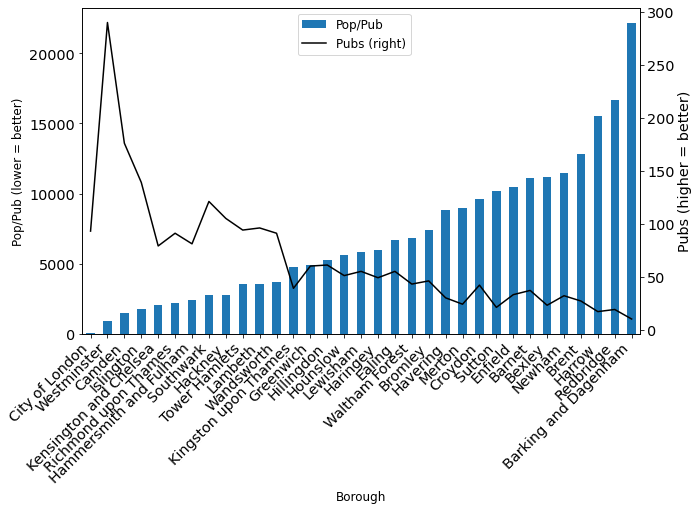

In [82]:
exp_chart = clusdata_df[['Borough', 'Pubs', 'Pop/Pub']].sort_values('Pop/Pub', ascending = True)
exp_chart.set_index('Borough', drop=True, inplace=True)

ax =  exp_chart.plot.bar(y='Pop/Pub', ylabel='Pop/Pub (lower = better)', fontsize='large')
exp_chart.plot(y='Pubs', fontsize='large', c='k', ax=ax, use_index=False, secondary_y=True, mark_right=True)
ax.right_ax.set_ylabel('Pubs (higher = better)', fontsize='large')
ax.get_legend().set_bbox_to_anchor((0.6, 1))
for label in ax.get_xticklabels():
  label.set_rotation(45)
  label.set_ha('right')

In [83]:
clusdata_df.describe().astype('int')

,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
count,33,33,33,33,33,33,33,33,33
mean,281758,47,7845,68,86,67,409,3,6951
std,79714,32,4215,3,9,55,225,6,5056
min,8164,2,2261,62,58,10,84,0,87
25%,244372,26,4743,65,85,32,216,0,2781
50%,292023,37,6233,68,88,51,375,1,5828
75%,337783,56,11511,72,93,91,558,4,10159
max,411275,150,16748,75,98,290,857,32,22149


In [84]:
clusdata_df.corr().round(2)

,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
Population,1.00,0.44,0.07,-0.09,-0.20,-0.13,0.34,-0.63,0.27
Area km2,0.44,1.00,-0.69,-0.72,0.27,-0.40,0.69,-0.49,0.34
Pop/km2,0.07,-0.69,1.00,0.81,-0.30,0.56,-0.65,0.20,-0.44
Working_Age_%,-0.09,-0.72,0.81,1.00,-0.17,0.63,-0.85,0.53,-0.68
Drinkers_%,-0.20,0.27,-0.30,-0.17,1.00,0.04,-0.03,-0.02,-0.31
Pubs,-0.13,-0.40,0.56,0.63,0.04,1.00,-0.69,0.55,-0.69
NN,0.34,0.69,-0.65,-0.85,-0.03,-0.69,1.00,-0.58,0.84
Pubs/km2,-0.63,-0.49,0.20,0.53,-0.02,0.55,-0.58,1.00,-0.53
Pop/Pub,0.27,0.34,-0.44,-0.68,-0.31,-0.69,0.84,-0.53,1.00


## 9. Clustering the Boroughs

In [85]:
demog_geo_data = pd.read_csv('demog_geo_data.csv', encoding='utf-8')
clusdata_df = demog_geo_data.drop(columns=['Drinkers', 'Drinkers/Pop %', 'Drinkers/km2', 'Ave dist', 'Drinkers/Pub'])
clusdata_df.head()

,Borough,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
0,Barking and Dagenham,221495,36.1,6135,63,75,10,745,0.3,22149
1,Barnet,411275,86.7,4743,65,88,37,720,0.4,11115
2,Bexley,256845,60.6,4238,63,95,23,765,0.4,11167
3,Brent,346437,43.2,8019,68,70,27,558,0.6,12831
4,Bromley,339466,150.1,2261,63,97,46,589,0.3,7379


In [ ]:
print(clusdata_df.columns.tolist())

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Data pre-processing/normalisation

In [87]:
# Normalising the dataset

X = clusdata_df.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-0.76770988, -0.35820372, -0.4120862 , -1.38047997, -1.18528027,
        -1.05404162,  1.5092706 , -0.51962623,  3.05199087],
       [ 1.64994686,  1.21292466, -0.74742591, -0.85984181,  0.17795093,
        -0.55975158,  1.39675042, -0.5027652 ,  0.83613304],
       [-0.31737704,  0.40252049, -0.86908292, -1.38047997,  0.9119985 ,
        -0.81605012,  1.59928673, -0.5027652 ,  0.84657572],
       [ 0.82395873, -0.13774895,  0.04177876, -0.07888457, -1.70959997,
        -0.74282196,  0.6676197 , -0.46904315,  1.18074171],
       [ 0.73515335,  3.18149262, -1.34535205, -1.38047997,  1.12172637,
        -0.39498823,  0.80714471, -0.51962623,  0.08586615],
       [-0.28554163, -0.80221826,  0.97576732,  0.70207267, -0.24150483,
         1.9849268 , -1.19571438,  0.79553396, -1.1001821 ],
       [-3.48538892, -1.38906266, -1.21189069,  1.22271083, -0.03177695,
         0.46544259, -1.46576279,  4.84218071, -1.37851987],
       [ 1.55040228,  1.20671466, -0.76645741, -0.85984181,  0

### Determining the optimal k using the 'elbow method'

Ref https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [88]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_dataset)
    Sum_of_squared_distances.append(km.inertia_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Plotting the Sum of squares vs k suggests optimal k = 4 or 5. I'll use 5.

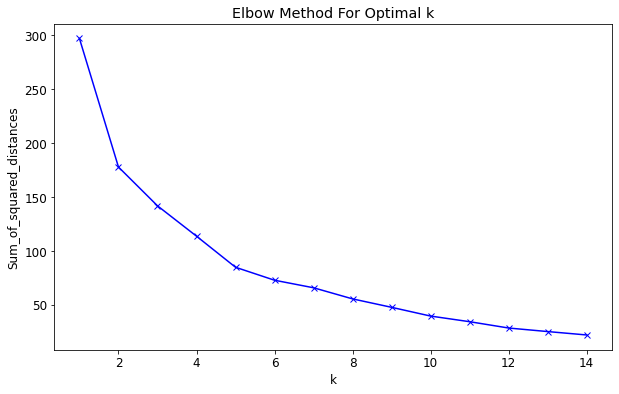

In [89]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [90]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(cluster_dataset)
labels = k_means.labels_
clusdata_df['Cluster'] = labels+1
clusdata_df.rename({'Cluster': 'Zone'}, axis=1, inplace=True)
clusdata_df

,Borough,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub,Zone
0,Barking and Dagenham,221495,36.1,6135,63,75,10,745,0.3,22149,5
1,Barnet,411275,86.7,4743,65,88,37,720,0.4,11115,4
2,Bexley,256845,60.6,4238,63,95,23,765,0.4,11167,4
3,Brent,346437,43.2,8019,68,70,27,558,0.6,12831,5
4,Bromley,339466,150.1,2261,63,97,46,589,0.3,7379,4
5,Camden,259344,21.8,11896,71,84,176,144,8.1,1473,3
6,City of London,8164,2.9,2815,73,86,93,84,32.1,87,2
7,Croydon,403461,86.5,4664,65,91,42,549,0.5,9606,4
8,Ealing,369685,55.5,6660,67,87,55,399,1.0,6721,1
9,Enfield,346635,80.8,4290,64,85,33,729,0.4,10504,4


In [91]:
df1 = clusdata_df.pop('Zone')
clusdata_df.insert(loc=0, column='Zone', value=df1)
clusdata_df

,Zone,Borough,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
0,5,Barking and Dagenham,221495,36.1,6135,63,75,10,745,0.3,22149
1,4,Barnet,411275,86.7,4743,65,88,37,720,0.4,11115
2,4,Bexley,256845,60.6,4238,63,95,23,765,0.4,11167
3,5,Brent,346437,43.2,8019,68,70,27,558,0.6,12831
4,4,Bromley,339466,150.1,2261,63,97,46,589,0.3,7379
5,3,Camden,259344,21.8,11896,71,84,176,144,8.1,1473
6,2,City of London,8164,2.9,2815,73,86,93,84,32.1,87
7,4,Croydon,403461,86.5,4664,65,91,42,549,0.5,9606
8,1,Ealing,369685,55.5,6660,67,87,55,399,1.0,6721
9,4,Enfield,346635,80.8,4290,64,85,33,729,0.4,10504


In [92]:
clusdata_df['Zone'].replace({4:1, 5:4, 1:5}, inplace=True)
clusdata_df.head()

,Zone,Borough,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
0,4,Barking and Dagenham,221495,36.1,6135,63,75,10,745,0.3,22149
1,1,Barnet,411275,86.7,4743,65,88,37,720,0.4,11115
2,1,Bexley,256845,60.6,4238,63,95,23,765,0.4,11167
3,4,Brent,346437,43.2,8019,68,70,27,558,0.6,12831
4,1,Bromley,339466,150.1,2261,63,97,46,589,0.3,7379


In [ ]:
clusdata_df.to_csv('clusdata_df.csv')

In [95]:
clusdata_sorted_df = clusdata_df.sort_values(['Zone','Borough'], ascending=True).reset_index(drop=True)
clusdata_sorted_df.to_csv('clusdata_sorted_df.csv', encoding='utf-8')

clusdata_sorted_df

,Zone,Borough,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
0,1,Barnet,411275,86.7,4743,65,88,37,720,0.4,11115
1,1,Bexley,256845,60.6,4238,63,95,23,765,0.4,11167
2,1,Bromley,339466,150.1,2261,63,97,46,589,0.3,7379
3,1,Croydon,403461,86.5,4664,65,91,42,549,0.5,9606
4,1,Enfield,346635,80.8,4290,64,85,33,729,0.4,10504
5,1,Havering,265930,112.4,2365,62,98,30,857,0.3,8864
6,1,Hillingdon,319467,115.7,2761,66,87,61,530,0.5,5237
7,2,City of London,8164,2.9,2815,73,86,93,84,32.1,87
8,3,Camden,259344,21.8,11896,71,84,176,144,8.1,1473
9,3,Hackney,292023,19.0,15369,72,87,105,212,5.5,2781


In [ ]:
print(clusdata_sorted_df.columns.tolist())

In [96]:
cluster_results = clusdata_sorted_df.groupby('Zone').mean().round(1)
convert_dict = {'Population': int, 'Pop/km2': int, 'Working_Age_%': int, 'Drinkers_%':int, 'Pubs': int, 'NN':int, 'Pop/Pub':int}
cluster_results = cluster_results.astype(convert_dict)
cluster_results.to_csv('cluster_results.csv')

cluster_results

,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
Zone,,,,,,,,,
1,334725,99.0,3617,64,91,38,677,0.4,9124
2,8164,2.9,2815,73,86,93,84,32.1,87
3,275992,21.6,13204,72,86,127,190,6.3,2493
4,302929,44.5,7022,66,72,21,634,0.5,15718
5,267221,43.8,6361,67,89,48,362,1.1,6191


In [97]:
print(cluster_results.columns.tolist())

['Population', 'Area km2', 'Pop/km2', 'Working_Age_%', 'Drinkers_%', 'Pubs', 'NN', 'Pubs/km2', 'Pop/Pub']


In [98]:
cluster_results.describe()

,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
count,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,237806.200000,42.36000,6603.800000,68.400000,84.800000,65.400000,389.400000,8.080000,6722.600000
std,131046.898737,36.06526,4094.888973,3.911521,7.463243,43.535043,262.832266,13.649982,6100.968063
min,8164.000000,2.90000,2815.000000,64.000000,72.000000,21.000000,84.000000,0.400000,87.000000
25%,267221.000000,21.60000,3617.000000,66.000000,86.000000,38.000000,190.000000,0.500000,2493.000000
50%,275992.000000,43.80000,6361.000000,67.000000,86.000000,48.000000,362.000000,1.100000,6191.000000
75%,302929.000000,44.50000,7022.000000,72.000000,89.000000,93.000000,634.000000,6.300000,9124.000000
max,334725.000000,99.00000,13204.000000,73.000000,91.000000,127.000000,677.000000,32.100000,15718.000000


In [99]:
# Add all Boroughs in single cell corresponding to cluster number

Zone1 = []
Zone2 = []
Zone3 = []
Zone4 = []
Zone5 = []

clus_boros = [Zone1, Zone2, Zone3, Zone4, Zone5]

for c, b in zip(clusdata_df['Zone'], clusdata_df['Borough']):
    if c == 1:
        Zone1.append(b)
    elif c == 2:
        Zone2.append(b)
    elif c == 3:
        Zone3.append(b)
    elif c == 4:
        Zone4.append(b)
    elif c == 5:
        Zone5.append(b)

cluster_results['Boroughs'] = clus_boros

cluster_results

,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub,Boroughs
Zone,,,,,,,,,,
1,334725,99.0,3617,64,91,38,677,0.4,9124,"[Barnet, Bexley, Bromley, Croydon, Enfield, Ha..."
2,8164,2.9,2815,73,86,93,84,32.1,87,[City of London]
3,275992,21.6,13204,72,86,127,190,6.3,2493,"[Camden, Hackney, Hammersmith and Fulham, Isli..."
4,302929,44.5,7022,66,72,21,634,0.5,15718,"[Barking and Dagenham, Brent, Harrow, Newham, ..."
5,267221,43.8,6361,67,89,48,362,1.1,6191,"[Ealing, Greenwich, Haringey, Hounslow, Kingst..."


In [100]:
temp = cluster_results.pop('Boroughs')
cluster_results.insert(loc=0, column='Boroughs', value=temp)
cluster_results

,Boroughs,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
Zone,,,,,,,,,,
1,"[Barnet, Bexley, Bromley, Croydon, Enfield, Ha...",334725,99.0,3617,64,91,38,677,0.4,9124
2,[City of London],8164,2.9,2815,73,86,93,84,32.1,87
3,"[Camden, Hackney, Hammersmith and Fulham, Isli...",275992,21.6,13204,72,86,127,190,6.3,2493
4,"[Barking and Dagenham, Brent, Harrow, Newham, ...",302929,44.5,7022,66,72,21,634,0.5,15718
5,"[Ealing, Greenwich, Haringey, Hounslow, Kingst...",267221,43.8,6361,67,89,48,362,1.1,6191


In [101]:
cluster_results['Boroughs'] = cluster_results['Boroughs'].astype('str')

In [102]:
cluster_results['Boroughs'] = cluster_results['Boroughs'].str.replace(r'[^,\- a-zA-Z0-9]','')
cluster_results

<ipython-input-102-3feaa99b0dd4>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cluster_results['Boroughs'] = cluster_results['Boroughs'].str.replace(r'[^,\- a-zA-Z0-9]','')


,Boroughs,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
Zone,,,,,,,,,,
1,"Barnet, Bexley, Bromley, Croydon, Enfield, Hav...",334725,99.0,3617,64,91,38,677,0.4,9124
2,City of London,8164,2.9,2815,73,86,93,84,32.1,87
3,"Camden, Hackney, Hammersmith and Fulham, Islin...",275992,21.6,13204,72,86,127,190,6.3,2493
4,"Barking and Dagenham, Brent, Harrow, Newham, R...",302929,44.5,7022,66,72,21,634,0.5,15718
5,"Ealing, Greenwich, Haringey, Hounslow, Kingsto...",267221,43.8,6361,67,89,48,362,1.1,6191


In [103]:
cluster_results.reset_index(drop=True)

,Boroughs,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
0,"Barnet, Bexley, Bromley, Croydon, Enfield, Hav...",334725,99.0,3617,64,91,38,677,0.4,9124
1,City of London,8164,2.9,2815,73,86,93,84,32.1,87
2,"Camden, Hackney, Hammersmith and Fulham, Islin...",275992,21.6,13204,72,86,127,190,6.3,2493
3,"Barking and Dagenham, Brent, Harrow, Newham, R...",302929,44.5,7022,66,72,21,634,0.5,15718
4,"Ealing, Greenwich, Haringey, Hounslow, Kingsto...",267221,43.8,6361,67,89,48,362,1.1,6191


In [104]:
cluster_results.reset_index(drop=True, inplace=True)

In [105]:
cluster_results

,Boroughs,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
0,"Barnet, Bexley, Bromley, Croydon, Enfield, Hav...",334725,99.0,3617,64,91,38,677,0.4,9124
1,City of London,8164,2.9,2815,73,86,93,84,32.1,87
2,"Camden, Hackney, Hammersmith and Fulham, Islin...",275992,21.6,13204,72,86,127,190,6.3,2493
3,"Barking and Dagenham, Brent, Harrow, Newham, R...",302929,44.5,7022,66,72,21,634,0.5,15718
4,"Ealing, Greenwich, Haringey, Hounslow, Kingsto...",267221,43.8,6361,67,89,48,362,1.1,6191


In [106]:
print(cluster_results.columns.tolist())

['Boroughs', 'Population', 'Area km2', 'Pop/km2', 'Working_Age_%', 'Drinkers_%', 'Pubs', 'NN', 'Pubs/km2', 'Pop/Pub']


In [ ]:
cluster_results.to_csv('cluster_summary2.csv')

In [107]:
clusdata_df['Zone'].dtype

dtype('int64')

In [108]:
boro_cluster_counts = clusdata_df['Zone'].value_counts().to_frame()
boro_cluster_counts.rename(columns={'Zone': 'B count'}, inplace=True)
boro_cluster_counts

,B count
3,10
5,10
1,7
4,5
2,1


In [ ]:
print(boro_cluster_counts.columns.tolist())

In [109]:
boro_cluster_counts.index_col='Zone'
boro_cluster_counts

,B count
3,10
5,10
1,7
4,5
2,1


In [ ]:
cluster_summary = pd.merge(left=cluster_results, right=boro_cluster_counts, left_on='Zone', right_on='Zone')
cluster_summary

In [ ]:
print(cluster_summary.columns.tolist())

In [ ]:
clus = cluster_summary.pop('B count')
cluster_summary.insert(loc=2, column='B count', value=clus)
cluster_summary.reset_index()
cluster_summary.head()

In [ ]:
cluster_summary.to_csv('cluster_summary3.csv', index=False)

In [114]:
cluster_summary = pd.read_csv('cluster_summary3.csv', encoding = 'utf-8')
cluster_summary.head()

,Zone,Boroughs,B count,Population,Area km2,Pop/km2,Working_Age_%,Drinkers_%,Pubs,NN,Pubs/km2,Pop/Pub
0,1,City of London,1,8164,2.9,2815,73,86,93,84,32.1,87
1,2,"Camden, Hackney, Hammersmith and Fulham, Islin...",10,275992,21.6,13204,72,86,127,190,6.3,2493
2,3,"Ealing, Greenwich, Haringey, Hounslow, Kingsto...",10,267221,43.8,6361,67,89,48,362,1.1,6191
3,4,"Barnet, Bexley, Bromley, Croydon, Enfield, Hav...",7,334725,99.0,3617,64,91,38,677,0.4,9124
4,5,"Barking and Dagenham, Brent, Harrow, Newham, R...",5,302929,44.5,7022,66,72,21,634,0.5,15718


## 10. Visualising the clustering results

In [115]:
import folium

print('Folium installed and imported!')

Folium installed and imported!


In [ ]:
## THIS MAP RESULTS IN A BIG FILE SO I'M ATTACHING THE OUTPUT AS AN IMAGE

clusdata_df = pd.read_csv('clusdata_df.csv', encoding = 'utf-8')
clusters_dict = []
clusters_dict = clusdata_df.set_index('Borough')['Zone']

london_map = folium.Map(location=[51.507222, -0.1275])

folium.GeoJson(
    london_data,
    style_function=lambda feature: {
     'fillColor': step(clusters_dict[feature['properties']['name']]),
        'color':'black',
        'weight': 2,
        'dashArray': '5, 5',
        'fillOpacity': 0.8,
    }
).add_to(london_map)

london_map

In [116]:
# define discrete colour bar for choropleth

import branca.colormap as cmp

step = cmp.StepColormap(
 ['purple', 'blue', 'green', 'orange', 'yellow'],
 vmin=0, vmax=5,
 caption='Clusters'
)
step

In [ ]:
# customised legend from https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd

from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Zone</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:purple;opacity:0.8;'></span>1</li>
    <li><span style='background:blue;opacity:0.8;'></span>2</li>
    <li><span style='background:green;opacity:0.8;'></span>3</li>
    <li><span style='background:orange;opacity:0.8;'></span>4</li>
    <li><span style='background:yellow;opacity:0.8;'></span>5</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

london_map.get_root().add_child(macro)

london_map

(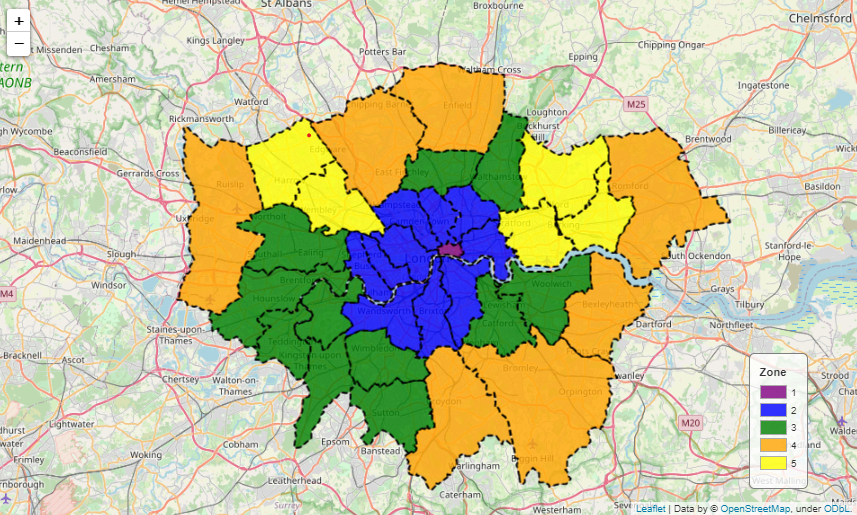)

## END!! Test code/experimentation follows ...

In [ ]:
print(clusdata_df['Borough'].dtype)
print(clusdata_df['Cluster'].dtype)

In [ ]:
clusdata_df[clusdata_df['Borough'] == 'Croydon']['Cluster']

In [ ]:
clusters_dict['Harrow']

In [ ]:
print(colormap)

In [ ]:
usa_polygons = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')
usa_polygons

In [ ]:
conda install -c plotly plotly

In [ ]:
import plotly.express as px

clusdata_sorted_df['Cluster'] = clusdata_sorted_df['Cluster'].astype('str')

df = clusdata_sorted_df
geojson = london_data

fig = px.choropleth(df, geojson=geojson, color="Cluster",
                    locations="Borough", featureidkey="properties.name",
                    projection="mercator", hover_data=['Cluster']
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()